# Section 1: Implementing the backpropagation for the Sign function

An important part of implementing any binary network is how we handle the backpropagation through the sign fucntion.
As shown below, the gradient of a mathematical sign function is zero almost everywhere and infinite at x=0, which is not useful for backpropagation.
Hence, we use what's called a straight through estimator (STE) to approximate the gradients for the sign function instead.
Essentially, we use the sign function in the forward pass but calculate the gradients as if we used a different function than the sign.
We will be using  the Clip function for this but other functions can be used, as long as the gradients are meaningfully defined.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# Random seed for reproducibility
np.random.seed(777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(777)
torch.backends.cudnn.enabled=True
torch.cuda.manual_seed(777)

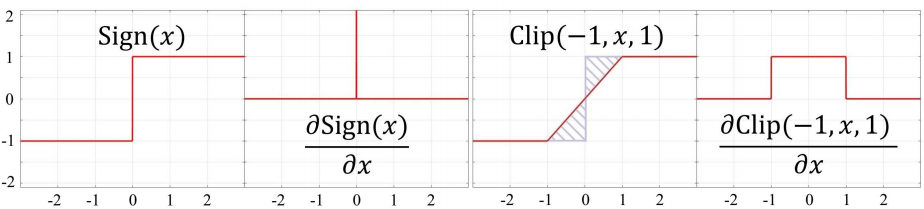

We will be using the AutoGrad functionality in PyTorch to implement the STE estimator for the Sign function. The forward part will be left unchanged but the backward part will be modified to calculate the gradients for the Clip function instead of the sign function.

In [ ]:
from torch.autograd import Function

class SignSTE(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)    #Saving the input for backward calculation.
        input = input.sign()            #Taking the sign function in the forward pass
        return input

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors      #Accessing the saved information (e.g. the input) for backward calculation

        ### Modify ###
        try:
          mask = None
          grad_input = None
        except:
          raise NotImplementedError
        ### Modify ###

        return grad_input


In [ ]:
# Test code for SignSTE implementation
weight = torch.tensor([0.5, -0.5], requires_grad=True)
weight_ste_sign = SignSTE().apply(weight)
grad = torch.tensor([1., 1.])
weight_ste_sign.backward(gradient=grad)
assert (torch.tensor([1.,1.]) == weight.grad).sum() == 2

With our STE implemented, we'll go through a very simple example showcasing how the SignSTE differs from the built-in sign function in PyTorch.
Namely, the built-in sign function will always output zero gradients, irrespective of what the input is.
On the other hand, SignSTE will output meaningful gradients when the inputs are between -1 and 1.

In [ ]:
W = torch.tensor([2., -0.5], requires_grad=True)
W_reg_sign = W.sign()

In [ ]:
W_reg_sign

tensor([ 1., -1.], grad_fn=<SignBackward>)

In [ ]:
external_grad = torch.tensor([1., 1.])
W_reg_sign.backward(gradient=external_grad)

In [ ]:
W.grad

tensor([0., 0.])

In [ ]:
W_ste_sign = SignSTE().apply(W)

In [ ]:
W_ste_sign

tensor([ 1., -1.], grad_fn=<SignSTEBackward>)

In [ ]:
external_grad = torch.tensor([1., 1.])
W_ste_sign.backward(gradient=external_grad)

In [ ]:
W.grad

tensor([0., 1.])

In practice, the SignSTE is only used for the activations and not the weights due to stability issues.
Hence, we'll use SignSTE to binarize the activations and SignWeight provided below to binarize the weights when we implement the binary convolutions.

In [ ]:
class SignWeight(Function):
    @staticmethod
    def forward(ctx, input):
        input = input.sign()
        return input

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.new_empty(grad_output.size())
        grad_input.copy_(grad_output)
        return grad_input

# Section 2: Implementing the binary convolution using our SignSTE function

We will now implement the binary convolution using the SignSTE and SignWeight classes. Recall how the binary convolution is calculated as shown below in (4). We will be 1) binarizing the input activations and weights using the SignSTE and SignWeight functions respectively, 2) calculate the convolutions as normal with the binarized values, and 3) calculate and multiply the scaling factor to the final output.

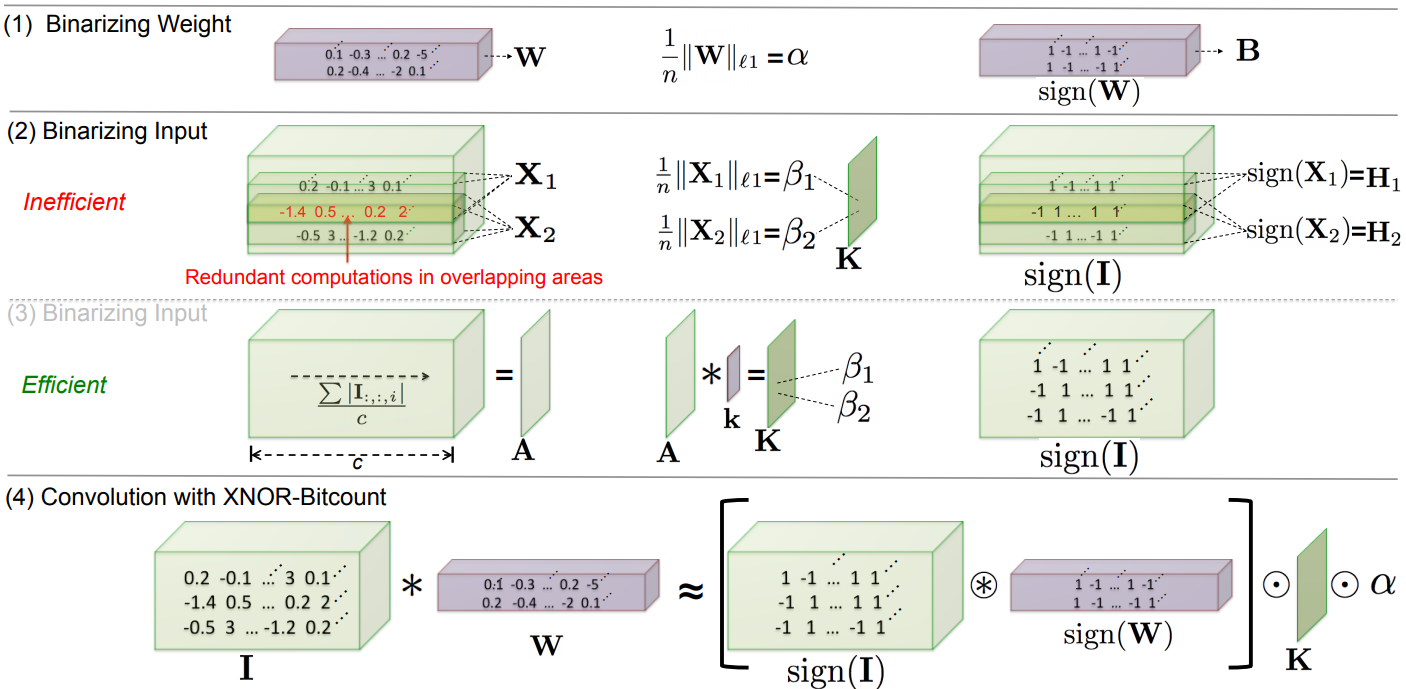

We calculate the scaling factors following the derivation below given in XNOR-Net. Note that we have two scaling factors, \\(\beta^{*} \\) and \\(\alpha^{*} \\), for the activations and the weights respectively. They are both essentially the average of all the absolute value of the elements in either the activation or the weight tensors.

**Note**: for computational efficiency, only \\(\alpha^{*} \\) is widely used as there is little performance difference but calculating \\(\beta^{*} \\) takes much more time. We will be following this convention and will only be using \\(\alpha^{*} \\) as our scaling factor.

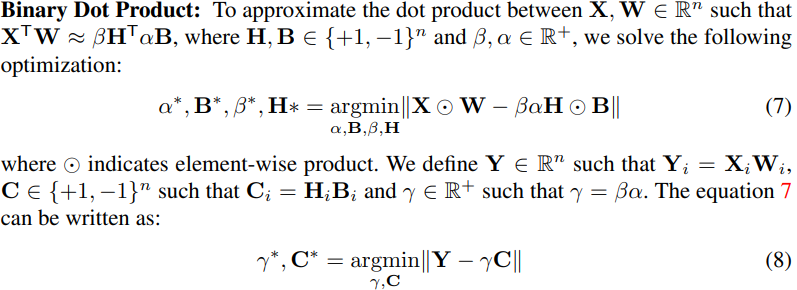
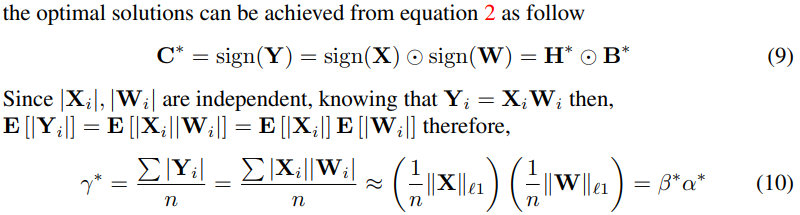

In [ ]:
class BinaryConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(BinaryConv2d, self).__init__(in_channels, out_channels,
              kernel_size, stride, padding, dilation, groups, bias)
        self.scaling_factor = None

    def forward(self, input):
        if self.training:
            ### MODIFY ###
            input = None
            self.weight_bin_tensor = None
            ### MODIFY ###
        else:
            # We clone the input here because it causes unexpected behaviors
            # to edit the data of `input` tensor.
            input = input.clone()
            input.data = input.sign()
            # Even though there is a UserWarning here, we have to use `new_tensor`
            # rather than the "recommended" way
            self.weight_bin_tensor = self.weight.new_tensor(self.weight.sign())
        ### MODIFY ###
        self.scaling_factor = None
        ### MODIFY ###
        try:
          self.scaling_factor = self.scaling_factor.detach()
          self.weight_bin_tensor = self.weight_bin_tensor * self.scaling_factor
          out = F.conv2d(input, self.weight_bin_tensor, self.bias, self.stride, self.padding, self.dilation, self.groups)
        except:
          raise NotImplementedError
        return out

In [ ]:
# Test code for BinaryConv2d implementation
binaryconv = BinaryConv2d(32,64, 3, 1, 1)
input = torch.randn(1, 32, 10,10)
output = binaryconv(input)
test_output = torch.randn(1,64,10,10)
assert test_output.shape == output.shape
assert abs(binaryconv.scaling_factor-0.0295) < 0.0005

NotImplementedError: ignored

Using the BinaryConv2d module, we will use the follwing 3x3 and 1x1 convolutions to build our ReActNet. Hence, whenever a 3x3 or a 1x1 convolution was used in MobileNetV1, the corresponding binaryconv3x3 and binaryconv1x1 will be used for ReActNet respectively.

In [ ]:
def binaryconv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return BinaryConv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


def binaryconv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return BinaryConv2d(in_planes, out_planes, kernel_size=1, stride=stride, padding=0)

# Section 3-1: Modifying the Downsampling blocks

Let's first implement the basic block of ReActNet, modified from MobileNetV1.
The number of blocks have been reduced from the original paper as we will be training on the CIFAR10 dataset instead of on the ImageNet dataset. The number of channels per block are given below.

In [ ]:
stage_out_channel = [32] + [64] + [128] * 2 + [256] * 6 + [512] * 2
print(stage_out_channel)

We will be using the "firstconv3x3" module (which will be given) and the "BasicBlock" module (which you will have to implement) to build ReActNet. The "firstconv3x3" module is handled separetely as this particular layer is kept floating point whereas other layers are all binarized.

In [ ]:
class firstconv3x3(nn.Module):
    def __init__(self, inp, oup, stride):
        super(firstconv3x3, self).__init__()

        self.conv1 = nn.Conv2d(inp, oup, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(oup)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)

        return out

The important aspects of the BasicBlock module is how to handle the case when the input and output channels of a block is different (e.g. the downsampling layers). Prior works used a floating point convolution to perform the downsampling whereas ReActNet uses 2 binary convolutions and concatenate the outputs instead.

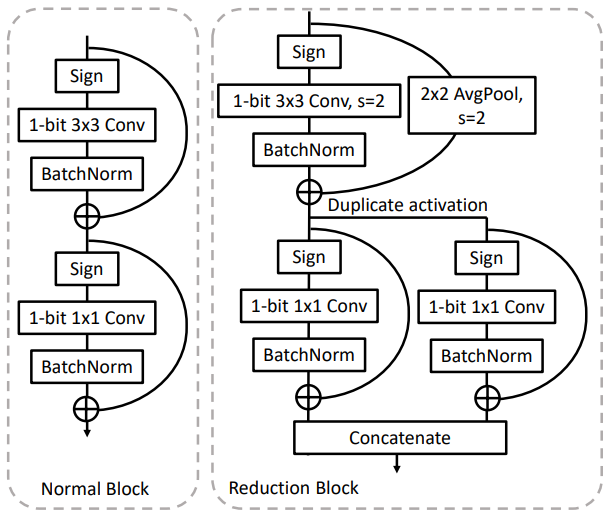

In [ ]:
class BasicBlock_(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock_, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.binary_3x3= binaryconv3x3(inplanes, inplanes, stride=stride)
        self.bn1 = norm_layer(inplanes)

        self.prelu1 = nn.PReLU(inplanes)


        if inplanes == planes:
            self.binary_pw = binaryconv1x1(inplanes, planes)
            self.bn2 = norm_layer(planes)
        else:
            ### MODIFY ###
            self.binary_pw_down1 = None       #Use binary 1x1 convolutions
            self.binary_pw_down2 = None
            self.bn2_1 = None                 #Use batch norm layers
            self.bn2_2 = None
            ### MODIFY ###

        self.prelu2 = nn.PReLU(planes)

        self.stride = stride
        self.inplanes = inplanes
        self.planes = planes

        if self.inplanes != self.planes:
            self.pooling = nn.AvgPool2d(2,2)

    def forward(self, x):

        out1 = self.binary_3x3(x)
        out1 = self.bn1(out1)

        if self.stride == 2:
            x = self.pooling(x)

        out1 = x + out1

        out1 = self.prelu1(out1)

        if self.inplanes == self.planes:
            try:
            ### MODIFY ###
              out2 = None # binary_pw -> bn2 -> residual connection
            ### MODIFY ###

        else:
            assert self.planes == self.inplanes * 2
            try:
            ### MODIFY ###
              out2_1 = None               #First convolution of the downsampling part -> bn2_1 -> residual connection
              out2_2 = None               #Second convolution of the downsampling part -> bn2_2 -> residual connection
              out2 = torch.cat([out2_1, out2_2], dim=1)
            ### MODIFY ###
            except:
              raise NotImplementedError
        out2 = self.prelu2(out2)

        return out2


In [ ]:
# Test code for BasicBlock_
basicblock_ = BasicBlock_(32,64,2)
input = torch.randn(1,32,10,10)
output = basicblock_(input)
test_output = torch.randn(1,64,5,5)
assert test_output.shape == output.shape

NotImplementedError: ignored

In [ ]:
# ReActNet without generalized activation function, i.e., ReAct-Sign and ReAct-PReLU
class reactnet_wo_act(nn.Module):
    def __init__(self, num_classes=10):
        super(reactnet_wo_act, self).__init__()
        self.feature = nn.ModuleList()
        for i in range(len(stage_out_channel)):
            if i == 0:
                self.feature.append(firstconv3x3(3, stage_out_channel[i], 1))
            elif stage_out_channel[i-1] != stage_out_channel[i] and stage_out_channel[i] != 64:
                self.feature.append(BasicBlock_(stage_out_channel[i-1], stage_out_channel[i], 2))
            else:
                self.feature.append(BasicBlock_(stage_out_channel[i-1], stage_out_channel[i], 1))
        self.pool1 = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        for i, block in enumerate(self.feature):
            x = block(x)

        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
model = reactnet_wo_act()
print(model)

# Section 3-2: Implementing the RSign and RPReLU functions

A key idea of ReActNet is to learn which thresholds for the binarization function (e.g. Sign) and the activation function (e.g. PReLU) we use. This is important because the important threshold for both functions is set at zero whilst binary network may have very different internal activation distributions. Hence, the idea is to learn the threshold for each channel of the input instead of using a hard-set value of zero all the time.

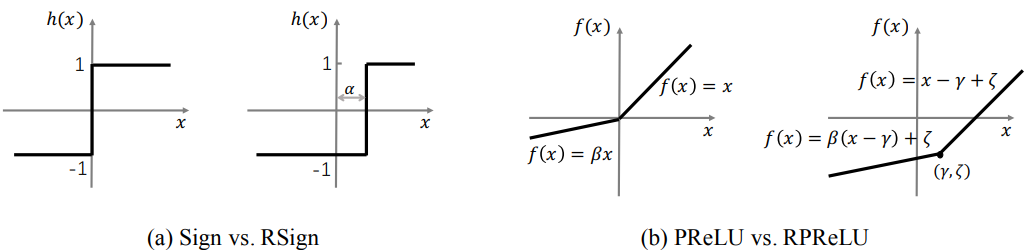

Using their modified RSign and RPReLU functions, we can finally build the BasicBlock of ReActNet. To implement the RSign and RPReLU function, we will be inserting a learnable channel-wise bias term right before (and after) the Sign and PReLU functions respectively.

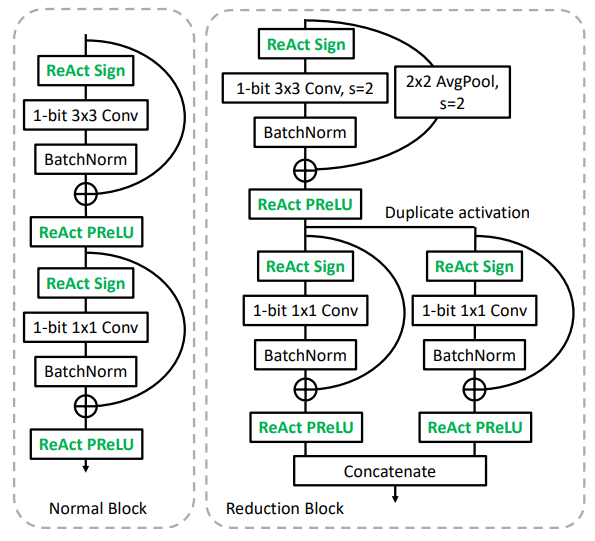

In [ ]:
class LearnableBias(nn.Module):
    def __init__(self, out_chn):
        super(LearnableBias, self).__init__()
        self.bias = nn.Parameter(torch.zeros(1,out_chn,1,1), requires_grad=True)

    def forward(self, x):
        out = x + self.bias.expand_as(x)
        return out

We will be naming the LearnableBias parameter variable names as "movexx" where "xx" will be a two digit indicator.

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        ### MODIFY ###
        self.move11 = None
        self.binary_3x3= binaryconv3x3(inplanes, inplanes, stride=stride)
        self.bn1 = norm_layer(inplanes)

        self.move12 = None
        self.prelu1 = nn.PReLU(inplanes)
        self.move13 = None

        self.move21 = None

        if inplanes == planes:
            self.binary_pw = binaryconv1x1(inplanes, planes)
            self.bn2 = norm_layer(planes)
        else:
            self.binary_pw_down1 = binaryconv1x1(inplanes, inplanes)
            self.binary_pw_down2 = binaryconv1x1(inplanes, inplanes)
            self.bn2_1 = norm_layer(inplanes)
            self.bn2_2 = norm_layer(inplanes)

        self.move22 = None
        self.prelu2 = nn.PReLU(planes)
        self.move23 = None
        ### MODIFY ###

        self.stride = stride
        self.inplanes = inplanes
        self.planes = planes

        if self.inplanes != self.planes:
            self.pooling = nn.AvgPool2d(2,2)

    def forward(self, x):
        try:
          ### MODIFY ###
          # RSign & RPReLU
          out1 = self.move11(x)

          out1 = self.binary_3x3(out1)
          out1 = self.bn1(out1)

          if self.stride == 2:
              x = self.pooling(x)

          out1 = x + out1

          out1 = None

          out2 = None

          if self.inplanes == self.planes:
              out2 = self.binary_pw(out2)
              out2 = self.bn2(out2)
              out2 += out1

          else:
              assert self.planes == self.inplanes * 2
              out2_1 = self.binary_pw_down1(out2)
              out2_2 = self.binary_pw_down2(out2)
              out2_1 = self.bn2_1(out2_1)
              out2_2 = self.bn2_2(out2_2)
              out2_1 += out1
              out2_2 += out1
              out2 = torch.cat([out2_1, out2_2], dim=1)

          # RPReLU
          out2 = None
          ### MODIFY ###
        except:
          raise NotImplementedError

        return out2


In [ ]:
# Test code for BasicBlock
basicblock = BasicBlock(32,64,2)
input = torch.randn(1,32,10,10)
output = basicblock(input)
test_output = torch.randn(1,64,5,5)
assert test_output.shape == output.shape

NotImplementedError: ignored

With our BasicBlock module implemented, ReActNet can be easily constructed via the following.

In [ ]:
class reactnet(nn.Module):
    def __init__(self, num_classes=10):
        super(reactnet, self).__init__()
        self.feature = nn.ModuleList()
        for i in range(len(stage_out_channel)):
            if i == 0:
                self.feature.append(firstconv3x3(3, stage_out_channel[i], 1))
            elif stage_out_channel[i-1] != stage_out_channel[i] and stage_out_channel[i] != 64:
                self.feature.append(BasicBlock(stage_out_channel[i-1], stage_out_channel[i], 2))
            else:
                self.feature.append(BasicBlock(stage_out_channel[i-1], stage_out_channel[i], 1))
        self.pool1 = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        for i, block in enumerate(self.feature):
            x = block(x)

        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
model = reactnet()

In [ ]:
print(model)

# Section 4: Training and testing ReActNet on the CIFAR10 dataset

Using our ReActNet, we will train it on the CIFAR10 dataset and see its test accuracy.
First, we will import needed libraries and define a useful helper functions for calculating and tracking loss and accuracy values during training

In [ ]:
import os
import sys
import logging
import argparse
import torch.utils
import torchvision.transforms as transforms
import torchvision.datasets as dset

In [ ]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt


def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].reshape(-1,).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

We will set some default hypyer-parameters and our logging procedure below.

In [ ]:
parser = argparse.ArgumentParser("cifar10-example")
parser.add_argument('--data', type=str, default='./data', help='location of the data corpus', required=False)
parser.add_argument('--batch_size', type=int, default=256, help='batch size', required=False)
parser.add_argument('--learning_rate', type=float, default=3e-4, help='init learning rate', required=False)
parser.add_argument('--report_freq', type=float, default=50, help='report frequency', required=False)
parser.add_argument('--epochs', type=int, default=10, help='num of training epochs', required=False)
parser.add_argument('--model_path', type=str, default='saved_models', help='path to save the model', required=False)
parser.add_argument('--save', type=str, default='ReActNet-CIFAR10-Toy', help='experiment name', required=False)
parser.add_argument('--seed', type=int, default=0, help='random seed', required=False)
sys.argv = ['-f']
args = parser.parse_args()

if not os.path.exists(args.save):
  os.mkdir(args.save)

log_format = '%(asctime)s %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
    format=log_format, datefmt='%m/%d %I:%M:%S %p')
fh = logging.FileHandler(os.path.join(args.save, 'log.txt'))
fh.setFormatter(logging.Formatter(log_format))
logging.getLogger().addHandler(fh)
logging.info("args = %s", args)

Below are basic train and inference loops.

In [ ]:
def train(train_queue, model, criterion, optimizer):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  model.train()

  for step, (input, target) in enumerate(train_queue):
    input = input.cuda()
    target = target.cuda()

    optimizer.zero_grad()
    logits= model(input)
    loss = criterion(logits, target)
    loss.backward()
    optimizer.step()
    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg


def infer(valid_queue, model, criterion):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  model.eval()
  with torch.no_grad():
    for step, (input, target) in enumerate(valid_queue):
      input = input.cuda()
      target = target.cuda()

      logits= model(input)
      loss = criterion(logits, target)

      prec1, prec5 = accuracy(logits, target, topk=(1, 5))
      n = input.size(0)
      objs.update(loss.item(), n)
      top1.update(prec1.item(), n)
      top5.update(prec5.item(), n)

      if step % args.report_freq == 0:
        logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)
  return top1.avg, objs.avg

We will now define modules that will be used in our training such as the model, optimizer, learning rate scheduler, and dataloaders.

In [ ]:
# ReActNet without generalized activation function

args.save = "ReActNet-wo-Act-CIFAR10-Toy"
if not os.path.exists(args.save):
    os.mkdir(args.save)

model = reactnet_wo_act().cuda()

criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
optimizer = torch.optim.Adam(
    model.parameters(),
    args.learning_rate,
    weight_decay=0.0
)

CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

train_data = dset.CIFAR10(root=args.data, train=True, download=True, transform=train_transform)
valid_data = dset.CIFAR10(root=args.data, train=False, download=True, transform=valid_transform)

train_queue = torch.utils.data.DataLoader(
    train_data, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=2)

valid_queue = torch.utils.data.DataLoader(
    valid_data, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=2)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, verbose=True)

In [ ]:
for epoch in range(args.epochs):
  logging.info('epoch %d lr %e', epoch, scheduler.get_lr()[0])

  train_acc, train_obj = train(train_queue, model, criterion, optimizer)
  logging.info('train_acc %f', train_acc)

  valid_acc, valid_obj = infer(valid_queue, model, criterion)
  logging.info('valid_acc %f', valid_acc)

  print('epoch %d lr %e', epoch, scheduler.get_lr()[0])
  print('train_acc %f', train_acc)
  print('valid_acc %f', valid_acc)

  scheduler.step()
torch.save(model.state_dict(), os.path.join(args.save, 'weights.pt'))

With the trained ReActNet without generalized activation function, let's plot the class-wise test accuracy using the below code.

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def class_wise_accuracy(valid_queue, model):
  model.eval()
  num_classes = len(classes)
  accs = [AvgrageMeter() for c in range(num_classes)]
  with torch.no_grad():
    for step, (input, target) in enumerate(valid_queue):
      input = input.cuda()
      target = target.cuda()
      output = model(input)
      _, preds = torch.max(output.data, 1)
      for c in range(num_classes):
        acc = ((preds==target).float() * (target == c).float()).sum() / max((target == c).float().sum(), 1.0)
        accs[c].update(acc.item(), input.size(0))
  for c in range(num_classes):
    accs[c] = (accs[c].avg)*100.
  return accs

In [ ]:
binary_class_wise_accs = class_wise_accuracy(valid_queue, model)

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(10)
fig = plt.figure(figsize=[12.8,9.6])
plt.bar(x, binary_class_wise_accs, zorder=3, label="ReActNet")
plt.xticks(x,classes, fontsize=25)
plt.xlabel('Classes',fontsize=30)
plt.ylabel('Classwise Top-1 Accuracy (%) ',fontsize=30)
plt.yticks([0., 20., 40, 60, 80, 100],fontsize=25)
plt.legend(bbox_to_anchor = (1,0.5),fontsize=40,facecolor=(0.97,0.97,0.97))
plt.grid(zorder=0)
plt.show()

---

---

In [ ]:
# ReActNet with generalized activation function

model = reactnet().cuda()

criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
optimizer = torch.optim.Adam(
    model.parameters(),
    args.learning_rate,
    weight_decay=0.0
)

CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

train_data = dset.CIFAR10(root=args.data, train=True, download=True, transform=train_transform)
valid_data = dset.CIFAR10(root=args.data, train=False, download=True, transform=valid_transform)

train_queue = torch.utils.data.DataLoader(
    train_data, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=2)

valid_queue = torch.utils.data.DataLoader(
    valid_data, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=2)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, verbose=True)

Below is a train loop that also calculates the test (validation) accuracy at every epoch. The final model is saved after the training is over.

In [ ]:
for epoch in range(args.epochs):
  logging.info('epoch %d lr %e', epoch, scheduler.get_lr()[0])

  train_acc, train_obj = train(train_queue, model, criterion, optimizer)
  logging.info('train_acc %f', train_acc)

  valid_acc, valid_obj = infer(valid_queue, model, criterion)
  logging.info('valid_acc %f', valid_acc)
  scheduler.step()
torch.save(model.state_dict(), os.path.join(args.save, 'weights.pt'))

With the trained ReActNet, let's plot the class-wise test accuracy using the below code.

In [ ]:
binary_class_wise_accs = class_wise_accuracy(valid_queue, model)

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(10)
fig = plt.figure(figsize=[12.8,9.6])
plt.bar(x, binary_class_wise_accs, zorder=3, label="ReActNet")
plt.xticks(x,classes, fontsize=25)
plt.xlabel('Classes',fontsize=30)
plt.ylabel('Classwise Top-1 Accuracy (%) ',fontsize=30)
plt.yticks([0., 20., 40, 60, 80, 100],fontsize=25)
plt.legend(bbox_to_anchor = (1,0.5),fontsize=40,facecolor=(0.97,0.97,0.97))
plt.grid(zorder=0)
plt.show()

---

---

# Section 5: Distributional loss

ReActNet actually uses a more complicated training scheme that involves multiple training of ReActNet with varying degrees of binarization and the use of a pretrained floating point teacher network. We will try out the second part corresponding to using a pretrained floating point teacher network.

Instead of using the CrossEntropy (CE) loss with the one-hot labels as the target, use the KLDiv loss with the softmax probabilities provided by the teacher network as the following. It is essentially just knowledge distillation without the CE term.

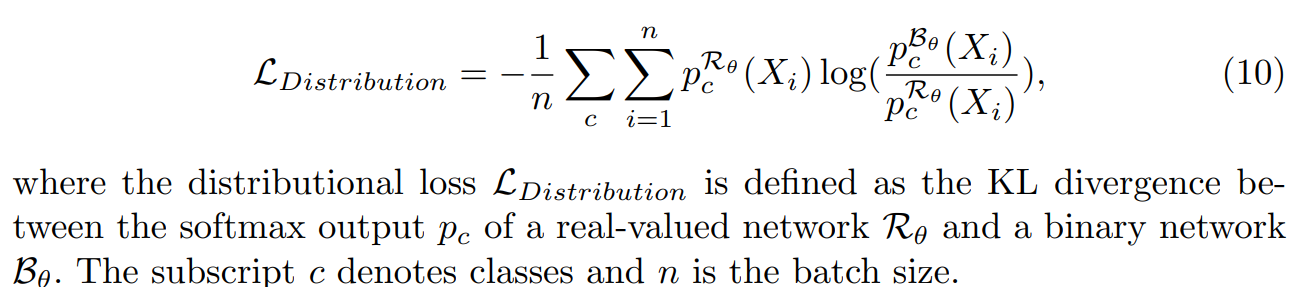

To use the distribution loss, we first need to define our new loss function as the following.

In [ ]:
# Taken from the official implementation found at https://github.com/liuzechun/ReActNey#L8t/blob/09ab2ea90162e9d7eb32cfded68e8428d3a30ea4/utils/KD_loss.p
from torch.nn.modules import loss

class DistributionLoss(loss._Loss):
    """The KL-Divergence loss for the binary student model and real teacher output.
    output must be a pair of (model_output, real_output), both NxC tensors.
    The rows of real_output must all add up to one (probability scores);
    however, model_output must be the pre-softmax output of the network."""

    def forward(self, model_output, real_output):

        self.size_average = True

        # Target is ignored at training time. Loss is defined as KL divergence
        # between the model output and the refined labels.
        if real_output.requires_grad:
            raise ValueError("real network output should not require gradients.")

        model_output_log_prob = F.log_softmax(model_output, dim=1)
        real_output_soft = F.softmax(real_output, dim=1)
        del model_output, real_output

        # Loss is -dot(model_output_log_prob, real_output). Prepare tensors
        # for batch matrix multiplication
        real_output_soft = real_output_soft.unsqueeze(1)
        model_output_log_prob = model_output_log_prob.unsqueeze(2)

        # Compute the loss, and average/sum for the batch.
        cross_entropy_loss = -torch.bmm(real_output_soft, model_output_log_prob)
        if self.size_average:
             cross_entropy_loss = cross_entropy_loss.mean()
        else:
             cross_entropy_loss = cross_entropy_loss.sum()
        # Return a pair of (loss_output, model_output). Model output will be
        # used for top-1 and top-5 evaluation.
        # model_output_log_prob = model_output_log_prob.squeeze(2)
        return cross_entropy_loss

We will also need to replace our train function with the below to accomodate the distribution loss.

In [ ]:
def train_distribution(train_queue, teacher, model, criterion, optimizer):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  model.train()
  teacher.eval()

  for step, (input, label) in enumerate(train_queue):
    input = input.cuda()
    label = label.cuda()
    optimizer.zero_grad()
    logits= model(input)
    with torch.no_grad():
        target = teacher(input)
    loss = criterion(logits, target)
    loss.backward()
    optimizer.step()
    prec1, prec5 = accuracy(logits, label, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

We will re-make our models, optimizer, and schedulers below.

In [ ]:
args.save = "ReActNet-CIFAR10-DistributionLoss-Toy"
if not os.path.exists(args.save):
  os.mkdir(args.save)
model = reactnet().cuda()

criterion_kl = DistributionLoss()
criterion_kl = criterion_kl.cuda()
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
optimizer = torch.optim.Adam(
    model.parameters(),
    args.learning_rate,
    weight_decay=0.0
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, verbose=True)

We will then load the pretrained floating point teacher network (ResNet20 trained on CIFAR10).

In [ ]:
!git clone https://github.com/gistvision/samsung_lecture.git

In [ ]:
from samsung_lecture.resnet_cifar10 import resnet20

In [ ]:
teacher = resnet20().cuda()
checkpoint = torch.load("/content/samsung_lecture/resnet20_parsed.pth")
teacher.load_state_dict(checkpoint['state_dict'])

In [ ]:
valid_acc, valid_obj = infer(valid_queue, teacher, nn.CrossEntropyLoss())
print("Top-1 test accuracy of the loaded teacher model: {}".format(valid_acc))

Below is a train loop that also calculates the test (validation) accuracy at every epoch. The final model is saved after the training is over.

In [ ]:
for epoch in range(args.epochs):
  logging.info('epoch %d lr %e', epoch, scheduler.get_lr()[0])

  train_acc, train_obj = train_distribution(train_queue, teacher, model, criterion_kl, optimizer)
  logging.info('train_acc %f', train_acc)

  valid_acc, valid_obj = infer(valid_queue, model, criterion)
  logging.info('valid_acc %f', valid_acc)
  scheduler.step()
torch.save(model.state_dict(), os.path.join(args.save, 'weights.pt'))

With the ReActNet trained with the distribution loss, let's plot the class-wise accuracy of ReActNet and the floating point teacher network.

In [ ]:
distribution_class_wise_acc = class_wise_accuracy(valid_queue, model)
fp_teacher_class_wise_acc = class_wise_accuracy(valid_queue, teacher)

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(10)
fig = plt.figure(figsize=[12.8,9.6])
plt.bar(x, distribution_class_wise_acc, zorder=3, label = 'ReActNet w/ Distribution Loss')
plt.bar(x, fp_teacher_class_wise_acc, zorder=2, label='FP Teacher')
plt.xticks(x,classes, fontsize=25)
plt.xlabel('Classes',fontsize=30)
plt.ylabel('Classwise Top-1 Accuracy (%) ',fontsize=30)
plt.yticks([0., 20., 40, 60, 80, 100],fontsize=25)
plt.grid(zorder=0)
plt.legend(bbox_to_anchor = (1,0.5),fontsize=40,facecolor=(0.97,0.97,0.97))
plt.show()